In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

# **Data loading and Preprocessing**

In [2]:
token_path = "/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'


doc = open(token_path,'r').read()
print(doc[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [3]:
# Make a dictionary having key(image id) and value(list of caption related to that image)
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]
            image_desc = ' '.join(tokens[1:])
            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)

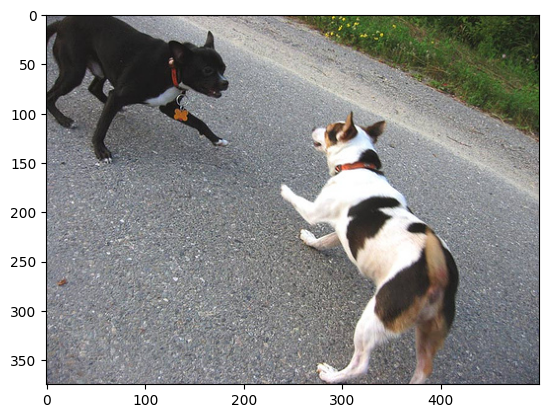

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [4]:
# demo of work done by above method
pic = '1001773457_577c3a7d70.jpg'
x=plt.imread(images_path+'/'+pic)
plt.imshow(x)
plt.show()
descriptions['1001773457_577c3a7d70']

In [5]:
# We create a vocabulary of all the unique words present across all the 8000*5 image captions in the dataset.
#We have 9630 unique words across all the 40000 image captions.
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 9630


In [6]:
#save the image id’s and their new cleaned captions in the same format as the token.txt file
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
        
new_descriptions = '\n'.join(lines)

In [7]:
new_descriptions[:93]

'1000268201_693b08cb0e A child in a pink dress is climbing up a set of stairs in an entry way '

In [8]:
# take the ids of training image from Flickr_8k.trainImages.txt file
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
        identifier= line.split('.')[0]
        dataset.append(identifier)

train = set(dataset)

In [9]:
#here we seperate train and test images
img = glob.glob(images_path + '/*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i.split('/')[6] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []

for i in img:
    
    if i.split('/')[6] in test_images: 
        test_img.append(i)

In [ ]:
train_img

In [10]:
img[0].split('/')

['',
 'kaggle',
 'input',
 'flickr8k-dataset',
 'Flickr8k_Dataset',
 'Flicker8k_Dataset',
 '3226254560_2f8ac147ea.jpg']

In [11]:
#addtwo tokens in every caption of training images, which are ‘startseq’ and ‘endseq’
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)


In [12]:
#Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [13]:
all_train_captions[:7]

['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq',
 'startseq A girl going into a wooden building . endseq',
 'startseq A little girl climbing into a wooden playhouse . endseq',
 'startseq A little girl climbing the stairs to her playhouse . endseq',
 'startseq A little girl in a pink dress going into a wooden cabin . endseq',
 'startseq A black dog and a spotted dog are fighting endseq',
 'startseq A black dog and a tri-colored dog playing with each other on the road . endseq']

In [14]:
#reduce our vocabulary to only those words which repeat at least 10 times in the entire corpus, to make
#model more robust
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1698


In [15]:
#create two dictionaries to map words to an index and vice versa
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1


In [16]:
#gettng maximum length of caption
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 40


# **Model Building and Training**

In [17]:
# load the model and remove last layer, we need to only extract image vector for our image.
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 [==============================] - 1s 0us/step


Since we are using InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras.

In [18]:
#process the image before feeding to model
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [19]:
#encode our training and testing images
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img] = encode(img)


1/1 [==============================] - 0s 160ms/step


In [20]:
#We are creating a Merge model where we combine the image vector and the caption.
from keras.layers import add
embedding_dim = 256
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 256)              434944    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

# **Model Training**

In [21]:
#weights train only one time
# model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [22]:
#compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1 = [] 
    X2 = []
    y = []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[images_path + '/' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1 = []
                X2 = []
                y = [] 
                n=0

In [24]:
epochs = 15
batch_size = 5
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
print(generator)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)



<generator object data_generator at 0x7e5783127df0>
Epoch 1/15
1200/1200 [==============================] - 635s 524ms/step - loss: 4.0056
Epoch 2/15
1200/1200 [==============================] - 632s 526ms/step - loss: 3.2948
Epoch 3/15
1200/1200 [==============================] - 625s 521ms/step - loss: 3.0588
Epoch 4/15
1200/1200 [==============================] - 617s 514ms/step - loss: 2.9115
Epoch 5/15
1200/1200 [==============================] - 611s 509ms/step - loss: 2.8042
Epoch 6/15
1200/1200 [==============================] - 605s 504ms/step - loss: 2.7178
Epoch 7/15
1200/1200 [==============================] - 607s 505ms/step - loss: 2.6478
Epoch 8/15
1200/1200 [==============================] - 615s 513ms/step - loss: 2.5892
Epoch 9/15
1200/1200 [==============================] - 617s 514ms/step - loss: 2.5383
Epoch 10/15
1200/1200 [==============================] - 641s 534ms/step - loss: 2.4929
Epoch 11/15
1200/1200 [==============================] - 696s 580ms/step - lo

In [25]:
# save the model
model.save('/kaggle/working/'+'/model8k.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# done with training, that will give a long vector with a probability distribution across all the words in the vocabulary.
#pick the word with the highest probability to get the next word prediction
def testing(photo):
    
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [27]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=c857c35653f54b967b57d2295e4dc87aaecc1dc44d84e394aa7ca18ebf83a2f8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [34]:
def get_list_of_caption(id):
    res = ''
    for val in descriptions[id]:
        res += val.lower()
        res += ','
    return res

In [62]:
def get_weight_list(n):
    weights = [1.0 / n] * n 
    return weights

In [63]:
#validating captions
# validate with test data

bl_score = []
b1_score = []
b2_score = []
b3_score = []
precision = []
recall = []
fmeasure = []
roug_score = {}


for key in test_img:
    key_id = key.split('/')[6][:-4]
    # get actual caption
    captions = descriptions[key_id]
    
    # predict the caption for image
    y_pred = testing(encoding_test[key].reshape((1,2048)))
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred_l = y_pred.split()
    
    bleu_scores = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(4)) #bydefault
    bleu_scores1 = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(1))
    bleu_scores2 = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(2))
    bleu_scores3 = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(3))
    bl_score.append(bleu_scores)
    b1_score.append(bleu_scores1)
    b2_score.append(bleu_scores2)
    b3_score.append(bleu_scores3)
    
    reference_captions = get_list_of_caption(image_id)
    scorer = rouge_scorer.RougeScorer(['rouge1'])
    roug_scores = scorer.score(reference_captions, y_pred)
    
    precision.append(roug_scores['rouge1'].precision)
    recall.append(roug_scores['rouge1'].recall)
    fmeasure.append(roug_scores['rouge1'].fmeasure)

  
    


BLEU-sore1 : 0.5752406593025818
BLEU-sore2 : 0.4171725921725614
BLEU-sore3 : 0.4336557708998373
BLEU-sore4 : 0.4877210050410607
roug score : {'precision': 0.40993354659616227, 'recall': 0.08933333333333322, 'fmeasure': 0.14505287185509158}


In [ ]:
# calcuate BLEU score
length = len(bl_score)
score = sum(bl_score)/length
score1 = sum(b1_score)/length
score2 = sum(b2_score)/length
score3 = sum(b3_score)/length

print(f"BLEU-sore1 : {score1}")
print(f"BLEU-sore2 : {score2}")
print(f"BLEU-sore3 : {score3}")
print(f"BLEU-sore4 : {score}")

precision_avg = sum(precision)/length
recall_avg = sum(recall)/length
fmeasure_avg = sum(fmeasure)/length
roug_score['precision'] = precision_avg
roug_score['recall'] = recall_avg
roug_score['fmeasure'] = fmeasure_avg
print(f"roug score : {roug_score}")

In [67]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk import ngrams

def calculate_bleu(reference, candidate, n):
    reference = [reference.split()]
    candidate = candidate.split()
    
    weights = [1.0 / n] * n  # Equal weights for BLEU-2 and BLEU-4
    
    reference_ngrams = [list(ngrams(ref, n)) for ref in reference]
    candidate_ngrams = list(ngrams(candidate, n))

    bleu_score = sentence_bleu(reference_ngrams, candidate_ngrams, weights=weights)
    return bleu_score

# Example usage:
reference_sentence = "This is the reference sentence."
candidate_sentence = "This is the candidate sentence."

bleu_1 = calculate_bleu(reference_sentence, candidate_sentence, 1)
bleu_2 = calculate_bleu(reference_sentence, candidate_sentence, 2)
bleu_3 = calculate_bleu(reference_sentence, candidate_sentence, 3)
bleu_4 = calculate_bleu(reference_sentence, candidate_sentence, 4)

print("BLEU-1 Score:", bleu_1)
print("BLEU-2 Score:", bleu_2)
print("BLEU-3 Score:", bleu_3)
print("BLEU-4 Score:", bleu_4)

print('Individual 1-gram: %f' % sentence_bleu(reference_sentence, candidate_sentence, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference_sentence, candidate_sentence, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference_sentence, candidate_sentence, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference_sentence, candidate_sentence, weights=(0, 0, 0, 1)))




BLEU-1 Score: 0.8
BLEU-2 Score: 0.408248290463863
BLEU-3 Score: 0.6933612743506347
BLEU-4 Score: 0
Individual 1-gram: 0.322581
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000


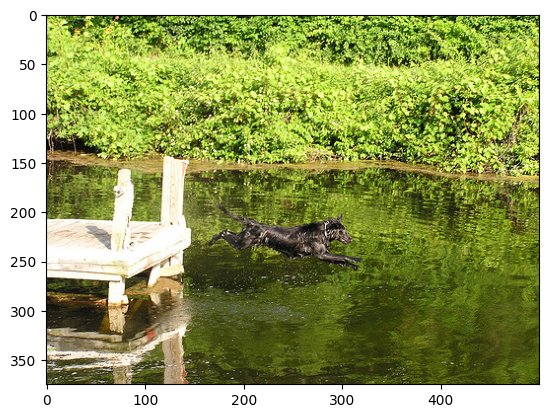

Predicted Caption: A dog swims in the water .
BLEU Score1: 0.2857142857142857
BLEU Score2: 0.5345224838248488
BLEU Score3: 0.6586337560083495
BLEU Score4: 0.7311104457090247
rouge1: Score(precision=0.6666666666666666, recall=0.06666666666666667, fmeasure=0.1212121212121212)


In [84]:
# pred_data = {}
# ori_data = {}
pic = list(encoding_test.keys())[7]

# image_id = pic.split('/')[6].split('.')[0]
# pred_data[image_id] = [testing(image)]
# ori_data[image_id] = descriptions[image_id]
image = encoding_test[pic].reshape((1,2048))



# Sample generated and reference captions
generated_captions = testing(image).lower()
reference_captions = get_list_of_caption(image_id)

# Tokenize captions
tokenized_gen_captions = generated_captions.split()
tokenized_ref_captions = reference_captions.split()
# Calculate BLEU scores
bleu_scores1 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(1))
bleu_scores2 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(2))
bleu_scores3 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(3))
bleu_scores = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions)

x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Predicted Caption:",testing(image))
print(f"BLEU Score1: {bleu_scores1}")
print(f"BLEU Score2: {bleu_scores2}")
print(f"BLEU Score3: {bleu_scores3}")
print(f"BLEU Score4: {bleu_scores}")

from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1'])
roug_scores = scorer.score(reference_captions, generated_captions)
for key in roug_scores:
    print(f'{key}: {roug_scores[key]}')


